In [ ]:
#@title Тестирование модели MediaPipe в режиме ВИДЕО: Режим декодированных кадров видео

Руководство по обнаружению ориентиров позы для Python

https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/python?hl=ru

In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Исходяшее видео
video_output_1 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_sync.mp4'
video_output_2 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_2_sync.mp4'
video_output_3 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'
video_output_4 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_4_sync.mp4'

output_video_list =[video_output_1, video_output_2, video_output_3, video_output_4]

In [ ]:
!pip install --upgrade -q pip mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 31.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from mediapipe.framework.formats import landmark_pb2

import subprocess
import os
from base64 import b64encode
from IPython.display import HTML
from tqdm import tqdm

In [ ]:
#Поза ориентира (облегченная)
!wget -O pose_landmarker_lite.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_lite/float16/latest/pose_landmarker_lite.task

In [ ]:
#Поза ориентира (Полная версия)
!wget -O pose_landmarker_full.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_full/float16/latest/pose_landmarker_full.task

In [ ]:
#Поза ориентира (тяжелая)
!wget -O pose_landmarker_heavy.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/latest/pose_landmarker_heavy.task

In [ ]:
#@title Функция детектирования видео

# Функция для отрисовки 3D поз
def plot_3d_pose(landmarks):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Извлечение координат
    x = [landmark.x for landmark in landmarks.landmark]
    y = [landmark.y for landmark in landmarks.landmark]
    z = [landmark.z for landmark in landmarks.landmark]

    ax.scatter(x, y, z)

    # Соединение ключевых точек
    connections = mp_pose.POSE_CONNECTIONS
    for connection in connections:
        ax.plot([x[connection[0]], x[connection[1]]],
                [y[connection[0]], y[connection[1]]],
                [z[connection[0]], z[connection[1]]], color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


def pose_detection_video (video_patch, models, pose_detection, pose_presence, tracking):

    video_drive_pose = f'{video_patch}_pose_{models}_{pose_detection}_{pose_presence}_{tracking}.mp4'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    PoseLandmarkerResult = mp.tasks.vision.PoseLandmarkerResult
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=models),
        running_mode=VisionRunningMode.VIDEO,
        min_pose_detection_confidence=pose_detection,
        min_pose_presence_confidence=pose_presence,
        min_tracking_confidence=tracking,
    )

    def draw_landmarks_on_image(rgb_image, detection_result):
        pose_landmarks_list = detection_result.pose_landmarks
        print ('pose_landmarks_list', pose_landmarks_list)
        #world_landmarks = detection_result.pose_world_landmarks
        #print ('world_landmarks', world_landmarks)
        annotated_image = np.copy(rgb_image)

        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])
            mp.solutions.drawing_utils.draw_landmarks(
                annotated_image,
                pose_landmarks_proto,
                mp.solutions.pose.POSE_CONNECTIONS,
                mp.solutions.drawing_styles.get_default_pose_landmarks_style())
        return annotated_image

    cap = cv2.VideoCapture(video_patch)

    # Получение ширины и высоты
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Получение общего количества кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Создание нового видеофайла для сохранения
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_drive_pose, fourcc, 30, (width, height))

    with PoseLandmarker.create_from_options(options) as landmarker:
        for _ in tqdm(range(total_frames), desc="Processing frames"):
            success, frame = cap.read()
            if not success:
                break  # Выход из цикла, если кадры закончились

            frame_timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

            detection_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)




            if detection_result:  # Проверяем, есть ли обнаруженные позы
                print ('Поза обнаружена', detection_result)
                #plot_3d_pose(detection_result)
                annotated_image = draw_landmarks_on_image(frame, detection_result)
                out.write(annotated_image)  # Запись кадра в новый видеофайл
            else:
                out.write(frame)

    # Освобождение ресурсов
    cap.release()
    out.release()

    print(f"Новое видео сохранено как {video_drive_pose}")

In [ ]:
pose_detection_video('/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_sync.mp4',"pose_landmarker_lite.task",0.5,0.5,0.5)

NameError: name 'mp' is not defined

In [ ]:
#Параметры модели
models = ["pose_landmarker_heavy.task"]
pose_detection = [0.5, 0.6, 0.7, 0.8, 0.9]
pose_presence = [0.5, 0.6, 0.7, 0.8, 0.9]
tracking = [0.5, 0.6, 0.7, 0.8, 0.9]

video_patch = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'

In [ ]:
#Параметры модели
models = ["pose_landmarker_lite.task", "pose_landmarker_full.task", "pose_landmarker_heavy.task"]
pose_detection = [0.1, 0.3]
pose_presence = [0.1, 0.3]
tracking = [0.1, 0.3]

video_patch = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4'

In [ ]:
# Прогоняем функцию по всем значениям
for model in models:
    for i in range(len(pose_detection)):
        pose_detection_video(video_patch, model, pose_detection[i], pose_presence[i], tracking[i])

Processing frames: 100%|██████████| 2671/2671 [03:36<00:00, 12.35it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_lite.task_0.1_0.1_0.1.mp4


Processing frames: 100%|██████████| 2671/2671 [03:37<00:00, 12.28it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_lite.task_0.3_0.3_0.3.mp4


Processing frames: 100%|██████████| 2671/2671 [04:16<00:00, 10.42it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.1_0.1_0.1.mp4


Processing frames: 100%|██████████| 2671/2671 [04:23<00:00, 10.14it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.3_0.3_0.3.mp4


Processing frames: 100%|██████████| 2671/2671 [10:28<00:00,  4.25it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_heavy.task_0.1_0.1_0.1.mp4


Processing frames: 100%|██████████| 2671/2671 [10:08<00:00,  4.39it/s]


Новое видео сохранено как /content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_heavy.task_0.3_0.3_0.3.mp4


In [ ]:
import numpy as np
import librosa
from moviepy.editor import VideoFileClip, clips_array

In [ ]:
#@title Плитка видео с разными моделями

# Путь к видео
video_outpu_1 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.5_0.5_0.5.mp4'
video_outpu_2 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_heavy.task_0.5_0.5_0.5.mp4'
video_outpu_3 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_lite.task_0.5_0.5_0.5.mp4'

# Загрузка видео
video_clips = [VideoFileClip(video_outpu_1), VideoFileClip(video_outpu_2), VideoFileClip(video_outpu_3), VideoFileClip(video_outpu_3)]

# Изменение размера видео
target_width = 1280
video_clips_resized = [clip.resize(width=target_width) for clip in video_clips]

# Создание плитки из видео
final_video = clips_array([[video_clips_resized[0], video_clips_resized[1]],
                            [video_clips_resized[2], video_clips_resized[2]]])

# Сохранение и вывод финального видео
final_video_path = '/content/drive/My Drive/video/pose/final_video_15.mp4'
final_video.write_videofile(final_video_path, codec='libx264')

NameError: name 'VideoFileClip' is not defined

https://drive.google.com/file/d/1N0FuMsSGSaqE9OpmrWxYsLiJiOuCT82p/view?usp=sharing

Лучше детектирует модель pose_landmarker_heavy.task

In [ ]:
#@title Плитка видео с разными моделями

from moviepy.editor import VideoFileClip, clips_array
import contextlib
import os
import sys

# Путь к видео
video_output_1 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.1_0.1_0.1.mp4'
video_output_2 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.3_0.3_0.3.mp4'
video_output_3 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.5_0.5_0.5.mp4'
video_output_4 = '/content/drive/My Drive/video/HEIAN_NIDAN_camera_3_sync.mp4_pose_pose_landmarker_full.task_0.7_0.7_0.7.mp4'

# Функция для подавления вывода
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            yield

# Загрузка видео
with suppress_output():
    video_clips = [VideoFileClip(video_output_1), VideoFileClip(video_output_2),
                   VideoFileClip(video_output_3), VideoFileClip(video_output_4)]

# Изменение размера видео
target_width = 1280
video_clips_resized = [clip.resize(width=target_width) for clip in video_clips]

# Создание плитки из видео
final_video = clips_array([[video_clips_resized[0], video_clips_resized[1]],
                            [video_clips_resized[2], video_clips_resized[3]]])

# Сохранение и вывод финального видео
final_video_path = '/content/drive/My Drive/video/pose/final_video_19.mp4'
with suppress_output():
    final_video.write_videofile(final_video_path)

https://drive.google.com/file/d/1-Q69-WpF8-4nS_J_jatvzDmk_nr3JU3w/view?usp=sharing

модель с параметрами
pose_detection = 0.1
pose_presence = 0.1
tracking = 0.1
раньше детектирует позы

In [ ]:
#@title Отрисовка в 3D

In [ ]:
#@title Функция для отрисовки 3D поз

import matplotlib.pyplot as plt
import numpy as np
import mediapipe as mp
import cv2
from tqdm import tqdm


def plot_3d_pose(detection_result):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Проверка на наличие обнаруженных поз
    if not detection_result.pose_landmarks:
        print("Нет обнаруженных поз.")
        return  # Завершаем выполнение функции, если позы не обнаружены

    # Извлечение координат из pose_landmarks
    pose_landmarks = detection_result.pose_landmarks[0]  # Берем первый набор поз
    x = [landmark.x for landmark in pose_landmarks]
    y = [landmark.y for landmark in pose_landmarks]
    z = [landmark.z for landmark in pose_landmarks]

    ax.scatter(x, y, z)

    # Соединение ключевых точек
    connections = mp.solutions.pose.POSE_CONNECTIONS
    for connection in connections:
        ax.plot([x[connection[0]], x[connection[1]]],
                [y[connection[0]], y[connection[1]]],
                [z[connection[0]], z[connection[1]]], color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


def pose_detection_video (video_patch, models, pose_detection, pose_presence, tracking):

    video_drive_pose = f'{video_patch}_pose_{models}_{pose_detection}_{pose_presence}_{tracking}.mp4'

    BaseOptions = mp.tasks.BaseOptions
    PoseLandmarker = mp.tasks.vision.PoseLandmarker
    PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
    PoseLandmarkerResult = mp.tasks.vision.PoseLandmarkerResult
    VisionRunningMode = mp.tasks.vision.RunningMode

    options = PoseLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=models),
        running_mode=VisionRunningMode.VIDEO,
        min_pose_detection_confidence=pose_detection,
        min_pose_presence_confidence=pose_presence,
        min_tracking_confidence=tracking,
    )

    def draw_landmarks_on_image(rgb_image, detection_result):
        pose_landmarks_list = detection_result.pose_landmarks
        annotated_image = np.copy(rgb_image)

        for idx in range(len(pose_landmarks_list)):
            pose_landmarks = pose_landmarks_list[idx]
            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])
            mp.solutions.drawing_utils.draw_landmarks(
                annotated_image,
                pose_landmarks_proto,
                mp.solutions.pose.POSE_CONNECTIONS,
                mp.solutions.drawing_styles.get_default_pose_landmarks_style())
        return annotated_image

    cap = cv2.VideoCapture(video_patch)

    # Получение ширины и высоты
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Получение общего количества кадров
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Создание нового видеофайла для сохранения
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(video_drive_pose, fourcc, 30, (width, height))

    with PoseLandmarker.create_from_options(options) as landmarker:
        for _ in tqdm(range(total_frames), desc="Processing frames"):
            success, frame = cap.read()
            if not success:
                break  # Выход из цикла, если кадры закончились

            frame_timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)

            detection_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)




            if detection_result:  # Проверяем, есть ли обнаруженные позы
                print ('Поза обнаружена', detection_result)
                plot_3d_pose(detection_result)
                annotated_image = draw_landmarks_on_image(frame, detection_result)
                out.write(annotated_image)  # Запись кадра в новый видеофайл
            else:
                out.write(frame)

    # Освобождение ресурсов
    cap.release()
    out.release()

Processing frames:   0%|          | 1/3603 [00:00<15:46,  3.81it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 2/3603 [00:00<14:47,  4.06it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 3/3603 [00:00<13:10,  4.55it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   0%|          | 4/3603 [00:00<12:34,  4.77it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 6/3603 [00:01<12:13,  4.90it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   0%|          | 7/3603 [00:01<11:41,  5.13it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 9/3603 [00:01<10:36,  5.65it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 11/3603 [00:02<23:05,  2.59it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 13/3603 [00:03<15:39,  3.82it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 15/3603 [00:03<11:57,  5.00it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   0%|          | 17/3603 [00:03<10:24,  5.74it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 19/3603 [00:04<10:01,  5.96it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 20/3603 [00:04<09:40,  6.17it/s]<ipython-input-33-eb78014cce39>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()
Processing frames:   1%|          | 21/3603 [00:04<09:11,  6.50it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 23/3603 [00:04<08:59,  6.63it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 25/3603 [00:04<09:11,  6.48it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 28/3603 [00:05<08:32,  6.97it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 29/3603 [00:05<08:28,  7.03it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 31/3603 [00:05<08:59,  6.62it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 34/3603 [00:06<08:30,  6.99it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 35/3603 [00:06<08:28,  7.02it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 37/3603 [00:06<08:45,  6.79it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 39/3603 [00:06<08:35,  6.91it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 42/3603 [00:07<08:34,  6.93it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|          | 44/3603 [00:07<08:17,  7.16it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|▏         | 46/3603 [00:07<08:09,  7.27it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|▏         | 48/3603 [00:08<08:28,  6.99it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|▏         | 49/3603 [00:08<08:20,  7.10it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|▏         | 52/3603 [00:08<08:34,  6.90it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   1%|▏         | 53/3603 [00:08<08:45,  6.76it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 56/3603 [00:09<08:32,  6.92it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 58/3603 [00:09<08:38,  6.84it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 59/3603 [00:09<08:43,  6.77it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 62/3603 [00:10<08:33,  6.90it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 64/3603 [00:10<08:26,  6.99it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 66/3603 [00:10<08:11,  7.20it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 67/3603 [00:11<08:35,  6.86it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 69/3603 [00:11<08:14,  7.14it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 70/3603 [00:11<16:43,  3.52it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 71/3603 [00:12<15:22,  3.83it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 72/3603 [00:12<14:31,  4.05it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 73/3603 [00:12<14:09,  4.16it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 74/3603 [00:12<12:59,  4.53it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 76/3603 [00:13<12:47,  4.60it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 77/3603 [00:13<12:21,  4.76it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.

Processing frames:   2%|▏         | 78/3603 [00:13<12:27,  4.72it/s]


Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 80/3603 [00:13<12:27,  4.71it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 81/3603 [00:14<12:16,  4.78it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 82/3603 [00:14<12:17,  4.78it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 83/3603 [00:14<11:35,  5.06it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 85/3603 [00:14<11:31,  5.08it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 86/3603 [00:15<11:33,  5.07it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 87/3603 [00:15<11:25,  5.13it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   2%|▏         | 89/3603 [00:15<11:03,  5.30it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   2%|▏         | 90/3603 [00:15<11:31,  5.08it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   3%|▎         | 91/3603 [00:16<12:00,  4.87it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 93/3603 [00:16<11:35,  5.04it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 94/3603 [00:16<11:55,  4.90it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 95/3603 [00:16<12:02,  4.86it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 96/3603 [00:17<12:45,  4.58it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 97/3603 [00:17<13:01,  4.48it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 98/3603 [00:17<12:23,  4.71it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 100/3603 [00:17<10:28,  5.57it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 102/3603 [00:18<09:37,  6.06it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 105/3603 [00:18<08:41,  6.71it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 106/3603 [00:18<08:56,  6.51it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 109/3603 [00:19<08:25,  6.92it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 110/3603 [00:19<08:17,  7.02it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 113/3603 [00:19<08:00,  7.27it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 114/3603 [00:19<08:01,  7.24it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 116/3603 [00:20<08:11,  7.10it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 118/3603 [00:20<08:17,  7.00it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 120/3603 [00:20<08:43,  6.66it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 122/3603 [00:21<08:51,  6.55it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 124/3603 [00:21<08:29,  6.83it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   3%|▎         | 126/3603 [00:21<08:26,  6.86it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▎         | 129/3603 [00:22<08:36,  6.72it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▎         | 131/3603 [00:22<08:37,  6.71it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▎         | 132/3603 [00:22<08:35,  6.74it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▎         | 134/3603 [00:22<08:38,  6.69it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▍         | 137/3603 [00:23<08:17,  6.97it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▍         | 138/3603 [00:23<08:37,  6.69it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.


Processing frames:   4%|▍         | 141/3603 [00:23<08:30,  6.78it/s]

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)


Processing frames:   4%|▍         | 143/3603 [00:24<13:12,  4.37it/s]

Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[], pose_world_landmarks=[], segmentation_masks=None)
Нет обнаруженных поз.
Поза обнаружена PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.9007453322410583, y=0.0805094838142395, z=0.11447823792695999, visibility=0.9985666871070862, presence=0.9998340606689453), NormalizedLandmark(x=0.9018349051475525, y=0.07378098368644714, z=0.09839831292629242, visibility=0.9992521405220032, presence=0.9998202919960022), NormalizedLandmark(x=0.9014491438865662, y=0.0734354555606842, z=0.0983731746673584, visibility=0.9992017149925232, presence=0.9998270869255066), NormalizedLandmark(x=0.9009184241294861, y=0.07272204756736755, z=0.09834758937358856, visibility=0.9993107318878174, presence=0.9998194575309753), NormalizedLandmark(x=0.9049698114395142, y=0.07887732982635498, z=0.11649136990308762, visibility=0.9989882111549377, presence=0.9998131394386292), NormalizedLandmark(x=0.9060234427452087, y=0.07930350303649

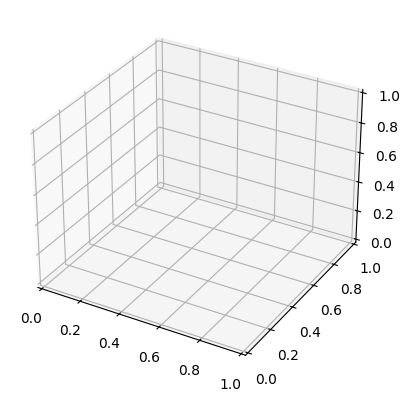

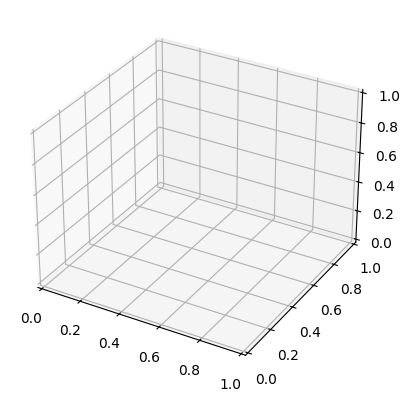

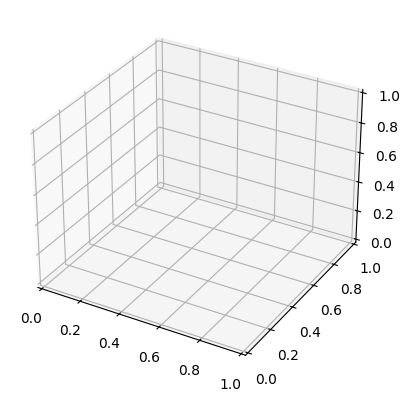

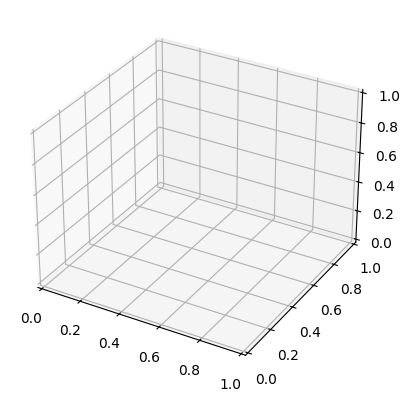

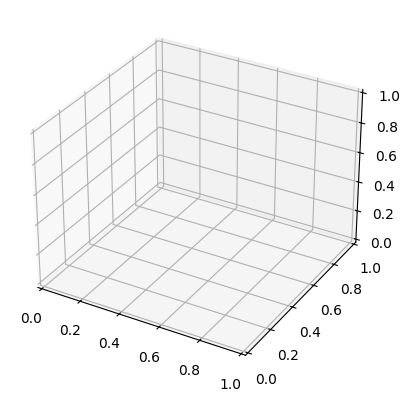

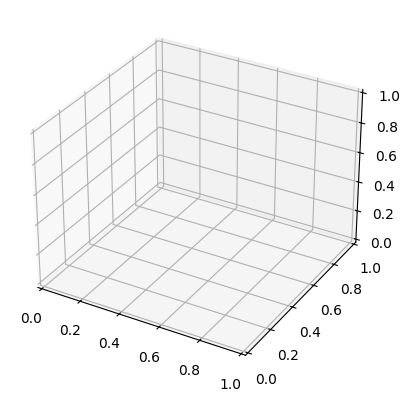

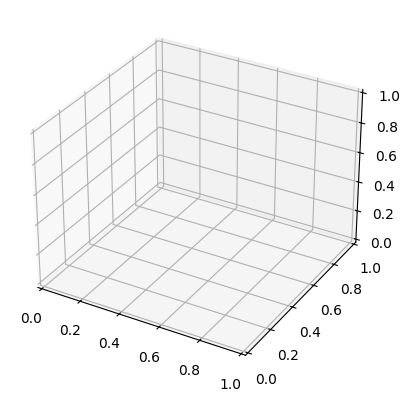

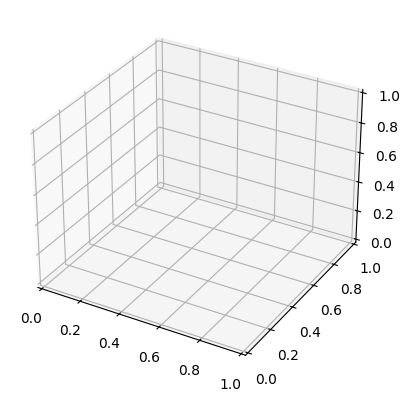

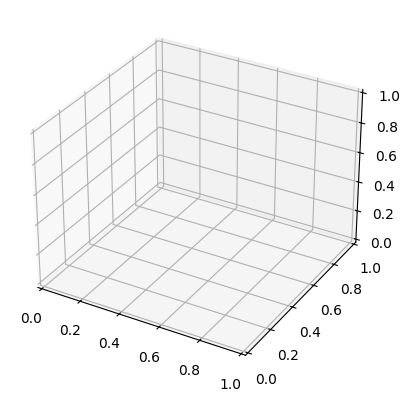

Processing frames:   4%|▍         | 143/3603 [00:26<10:52,  5.30it/s]


KeyboardInterrupt: 

In [ ]:
pose_detection_video('/content/drive/My Drive/video/HEIAN_NIDAN_camera_1_sync.mp4',"pose_landmarker_lite.task",0.5,0.5,0.5)

Поза обнаружена PoseLandmarkerResult(pose_landmarks=[[NormalizedLandmark(x=0.8831155300140381, y=0.08005029708147049, z=0.03446170687675476, visibility=0.9987432360649109, presence=0.9999521970748901), NormalizedLandmark(x=0.8853307366371155, y=0.07310817390680313, z=0.022814081981778145, visibility=0.9993240833282471, presence=0.9999442100524902), NormalizedLandmark(x=0.885552167892456, y=0.07286777347326279, z=0.02281072922050953, visibility=0.9992742538452148, presence=0.9999504089355469), NormalizedLandmark(x=0.8856995701789856, y=0.07233185321092606, z=0.022807857021689415, visibility=0.9993830919265747, presence=0.9999481439590454), NormalizedLandmark(x=0.8861066699028015, y=0.07508380711078644, z=0.03773549571633339, visibility=0.9990846514701843, presence=0.9999340772628784), NormalizedLandmark(x=0.8869098424911499, y=0.0752953439950943, z=0.03770054876804352, visibility=0.9987382292747498, presence=0.9999275207519531), NormalizedLandmark(x=0.8885803818702698, y=0.07544473558664322, z=0.03770913928747177, visibility=0.9988757371902466, presence=0.9999127388000488), NormalizedLandmark(x=0.8902668356895447, y=0.07938601821660995, z=-0.015533301047980785, visibility=0.9984558820724487, presence=0.9999552965164185), NormalizedLandmark(x=0.8950318098068237, y=0.08294622600078583, z=0.05238184705376625, visibility=0.9983193278312683, presence=0.9999197721481323), NormalizedLandmark(x=0.8840364813804626, y=0.08611303567886353, z=0.022706564515829086, visibility=0.9982447028160095, presence=0.9999517202377319), NormalizedLandmark(x=0.8847594857215881, y=0.09037213772535324, z=0.04235632345080376, visibility=0.9976097345352173, presence=0.999919056892395), NormalizedLandmark(x=0.8909617066383362, y=0.12839341163635254, z=-0.058214668184518814, visibility=0.9999316930770874, presence=0.9999693632125854), NormalizedLandmark(x=0.9094297289848328, y=0.13963936269283295, z=0.08423735946416855, visibility=0.9991796612739563, presence=0.9998226761817932), NormalizedLandmark(x=0.890450119972229, y=0.20469030737876892, z=-0.09805562347173691, visibility=0.7702089548110962, presence=0.9997729659080505), NormalizedLandmark(x=0.9052359461784363, y=0.2114090621471405, z=0.09972820430994034, visibility=0.0721902921795845, presence=0.9993959665298462), NormalizedLandmark(x=0.880045473575592, y=0.24118079245090485, z=-0.10405261069536209, visibility=0.52784264087677, presence=0.9987006187438965), NormalizedLandmark(x=0.8913334012031555, y=0.25394827127456665, z=0.07571277022361755, visibility=0.0970378965139389, presence=0.9980515241622925), NormalizedLandmark(x=0.883077085018158, y=0.26381808519363403, z=-0.1172746866941452, visibility=0.48512184619903564, presence=0.9976108074188232), NormalizedLandmark(x=0.8883852958679199, y=0.2647426128387451, z=0.07539259642362595, visibility=0.10872854292392731, presence=0.9972531199455261), NormalizedLandmark(x=0.8812168836593628, y=0.261496365070343, z=-0.11511668562889099, visibility=0.47266149520874023, presence=0.9977593421936035), NormalizedLandmark(x=0.8865806460380554, y=0.26390811800956726, z=0.06604854017496109, visibility=0.10887663811445236, presence=0.9973430037498474), NormalizedLandmark(x=0.8825073838233948, y=0.2565178871154785, z=-0.1021009013056755, visibility=0.4556196331977844, presence=0.9982948899269104), NormalizedLandmark(x=0.8874438405036926, y=0.2605985403060913, z=0.07064606249332428, visibility=0.10850318521261215, presence=0.9978076815605164), NormalizedLandmark(x=0.881901204586029, y=0.2969045341014862, z=-0.04911602661013603, visibility=0.9998893141746521, presence=0.9999537467956543), NormalizedLandmark(x=0.8945885896682739, y=0.298302561044693, z=0.049138132482767105, visibility=0.9996976852416992, presence=0.9999498128890991), NormalizedLandmark(x=0.8493600487709045, y=0.37553301453590393, z=-0.08605479449033737, visibility=0.9417416453361511, presence=0.9995357990264893), NormalizedLandmark(x=0.908125638961792, y=0.40438953042030334, z=0.06563885509967804, visibility=0.49844470620155334, presence=0.9996321201324463), NormalizedLandmark(x=0.8173513412475586, y=0.4671138823032379, z=-0.08640105277299881, visibility=0.9393028020858765, presence=0.9959523677825928), NormalizedLandmark(x=0.9249817728996277, y=0.5182268619537354, z=0.09244667738676071, visibility=0.713214099407196, presence=0.9961084723472595), NormalizedLandmark(x=0.8187897205352783, y=0.5052838921546936, z=-0.08788199722766876, visibility=0.9142993688583374, presence=0.9927366971969604), NormalizedLandmark(x=0.9298651218414307, y=0.5368452668190002, z=0.09497624635696411, visibility=0.8038890361785889, presence=0.9936349391937256), NormalizedLandmark(x=0.7961735725402832, y=0.4777485728263855, z=-0.12753073871135712, visibility=0.882068395614624, presence=0.9899399876594543), NormalizedLandmark(x=0.9162543416023254, y=0.5288334488868713, z=0.07829686999320984, visibility=0.6658434867858887, presence=0.9925695061683655)]], pose_world_landmarks=[[Landmark(x=-0.0507207028567791, y=-0.6338025331497192, z=0.06572577357292175, visibility=0.9987432360649109, presence=0.9999521970748901), Landmark(x=-0.033873118460178375, y=-0.663955807685852, z=0.037573717534542084, visibility=0.9993240833282471, presence=0.9999442100524902), Landmark(x=-0.03440588712692261, y=-0.6639761924743652, z=0.036046892404556274, visibility=0.9992742538452148, presence=0.9999504089355469), Landmark(x=-0.03409091383218765, y=-0.6644006967544556, z=0.03794306889176369, visibility=0.9993830919265747, presence=0.9999481439590454), Landmark(x=-0.028676794841885567, y=-0.6693102717399597, z=0.06395039707422256, visibility=0.9990846514701843, presence=0.9999340772628784), Landmark(x=-0.026407795026898384, y=-0.6699802279472351, z=0.06370419263839722, visibility=0.9987382292747498, presence=0.9999275207519531), Landmark(x=-0.027280176058411598, y=-0.6691169738769531, z=0.06748242676258087, visibility=0.9988757371902466, presence=0.9999127388000488), Landmark(x=0.04037909954786301, y=-0.622687041759491, z=-0.03413432091474533, visibility=0.9984558820724487, presence=0.9999552965164185), Landmark(x=0.07592616975307465, y=-0.6426090598106384, z=0.09625755995512009, visibility=0.9983193278312683, presence=0.9999197721481323), Landmark(x=-0.027915889397263527, y=-0.5974891781806946, z=0.03631997108459473, visibility=0.9982447028160095, presence=0.9999517202377319), Landmark(x=-0.0177940484136343, y=-0.6014032959938049, z=0.0746663436293602, visibility=0.9976097345352173, presence=0.999919056892395), Landmark(x=0.032813895493745804, y=-0.4593876004219055, z=-0.11316626518964767, visibility=0.9999316930770874, presence=0.9999693632125854), Landmark(x=0.11301197856664658, y=-0.4606085419654846, z=0.15953928232192993, visibility=0.9991796612739563, presence=0.9998226761817932), Landmark(x=0.01935916766524315, y=-0.2588389813899994, z=-0.1705314666032791, visibility=0.7702089548110962, presence=0.9997729659080505), Landmark(x=0.07859010249376297, y=-0.25643742084503174, z=0.18425755202770233, visibility=0.0721902921795845, presence=0.9993959665298462), Landmark(x=-0.011415704153478146, y=-0.11988718062639236, z=-0.1873055100440979, visibility=0.52784264087677, presence=0.9987006187438965), Landmark(x=-0.009326542727649212, y=-0.11849634349346161, z=0.1446927934885025, visibility=0.0970378965139389, presence=0.9980515241622925), Landmark(x=-0.015733452513813972, y=-0.09005437791347504, z=-0.20896852016448975, visibility=0.48512184619903564, presence=0.9976108074188232), Landmark(x=-0.028041934594511986, y=-0.0977523997426033, z=0.13353072106838226, visibility=0.10872854292392731, presence=0.9972531199455261), Landmark(x=-0.02383074164390564, y=-0.09580497443675995, z=-0.20915953814983368, visibility=0.47266149520874023, presence=0.9977593421936035), Landmark(x=-0.03347967192530632, y=-0.10316960513591766, z=0.11439700424671173, visibility=0.10887663811445236, presence=0.9973430037498474), Landmark(x=-0.015252459794282913, y=-0.11600079387426376, z=-0.1870465874671936, visibility=0.4556196331977844, presence=0.9982948899269104), Landmark(x=-0.01289540808647871, y=-0.11235711723566055, z=0.13427993655204773, visibility=0.10850318521261215, presence=0.9978076815605164), Landmark(x=-0.02295609749853611, y=-0.009969021193683147, z=-0.0924370214343071, visibility=0.9998893141746521, presence=0.9999537467956543), Landmark(x=0.022332480177283287, y=0.009432931430637836, z=0.09306991845369339, visibility=0.9996976852416992, presence=0.9999498128890991), Landmark(x=-0.2100774496793747, y=0.19576120376586914, z=-0.1378769874572754, visibility=0.9417416453361511, presence=0.9995357990264893), Landmark(x=0.09159579873085022, y=0.3298811614513397, z=0.11628668010234833, visibility=0.49844470620155334, presence=0.9996321201324463), Landmark(x=-0.37465664744377136, y=0.5274419188499451, z=-0.12242965400218964, visibility=0.9393028020858765, presence=0.9959523677825928), Landmark(x=0.21663646399974823, y=0.6529504060745239, z=0.1791580319404602, visibility=0.713214099407196, presence=0.9961084723472595), Landmark(x=-0.3931311070919037, y=0.5684757232666016, z=-0.12499367445707321, visibility=0.9142993688583374, presence=0.9927366971969604), Landmark(x=0.22792337834835052, y=0.6893554925918579, z=0.18316826224327087, visibility=0.8038890361785889, presence=0.9936349391937256), Landmark(x=-0.4951651692390442, y=0.5685555338859558, z=-0.1895534247159958, visibility=0.882068395614624, presence=0.9899399876594543), Landmark(x=0.16396084427833557, y=0.7161799669265747, z=0.14571629464626312, visibility=0.6658434867858887, presence=0.9925695061683655)]], segmentation_masks=None)
Поза

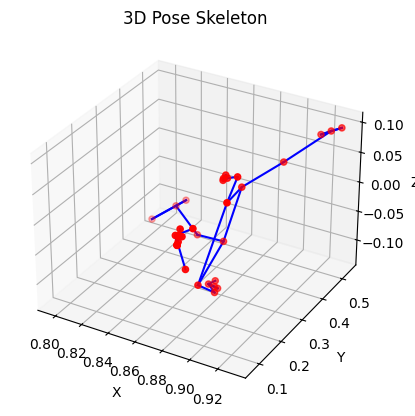

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Данные о позе
pose_landmarks = [
    [0.8831155300140381, 0.08005029708147049, 0.03446170687675476],
    [0.8853307366371155, 0.07310817390680313, 0.022814081981778145],
    [0.885552167892456, 0.07286777347326279, 0.02281072922050953],
    [0.8856995701789856, 0.07233185321092606, 0.022807857021689415],
    [0.8861066699028015, 0.07508380711078644, 0.03773549571633339],
    [0.8869098424911499, 0.0752953439950943, 0.03770054876804352],
    [0.8885803818702698, 0.07544473558664322, 0.03770913928747177],
    [0.8902668356895447, 0.07938601821660995, -0.015533301047980785],
    [0.8950318098068237, 0.08294622600078583, 0.05238184705376625],
    [0.8840364813804626, 0.08611303567886353, 0.022706564515829086],
    [0.8847594857215881, 0.09037213772535324, 0.04235632345080376],
    [0.8909617066383362, 0.12839341163635254, -0.058214668184518814],
    [0.9094297289848328, 0.13963936269283295, 0.08423735946416855],
    [0.890450119972229, 0.20469030737876892, -0.09805562347173691],
    [0.9052359461784363, 0.2114090621471405, 0.09972820430994034],
    [0.880045473575592, 0.24118079245090485, -0.10405261069536209],
    [0.8913334012031555, 0.25394827127456665, 0.07571277022361755],
    [0.883077085018158, 0.26381808519363403, -0.1172746866941452],
    [0.8883852958679199, 0.2647426128387451, 0.07539259642362595],
    [0.8812168836593628, 0.261496365070343, -0.11511668562889099],
    [0.8865806460380554, 0.26390811800956726, 0.06604854017496109],
    [0.8825073838233948, 0.2565178871154785, -0.1021009013056755],
    [0.8874438405036926, 0.2605985403060913, 0.07064606249332428],
    [0.881901204586029, 0.2969045341014862, -0.04911602661013603],
    [0.8945885896682739, 0.298302561044693, 0.049138132482767105],
    [0.8493600487709045, 0.37553301453590393, -0.08605479449033737],
    [0.908125638961792, 0.40438953042030334, 0.06563885509967804],
    [0.8173513412475586, 0.4671138823032379, -0.08640105277299881],
    [0.9249817728996277, 0.5182268619537354, 0.09244667738676071],
    [0.8187897205352783, 0.5052838921546936, -0.08788199722766876],
    [0.9298651218414307, 0.5368452668190002, 0.09497624635696411],
    [0.7961735725402832, 0.4777485728263855, -0.12753073871135712],
    [0.9162543416023254, 0.5288334488868713, 0.07829686999320984]
]

# Определяем связи между точками (скелет)
connections = [
    (0, 1), (1, 2), (2, 3),  # nose to left eye
    (0, 4), (4, 5), (5, 6),  # nose to right eye
    (0, 7), (0, 8),          # nose to ears
    (9, 10),                 # mouth
    (11, 12),                # shoulders
    (11, 13), (12, 14),     # shoulders to elbows
    (13, 15), (14, 16),     # elbows to wrists
    (15, 17), (16, 18),     # wrists to pinkies
    (15, 19), (16, 20),     # wrists to indexes
    (20, 18), (19, 17),
    (15, 21), (16, 22),     # wrists to thumbs
    (11, 23), (12, 24),     # shoulders to hips
    (23, 24),
    (23, 25), (24, 26),     # hips to knees
    (25, 27), (26, 28),     # knees to ankles
    (27, 29), (28, 30),     # ankles to heels
    (29, 31), (30, 32),      # heels to foot indexes
    (27, 31), (28, 32)
]

# Преобразуем данные в массив NumPy
pose_landmarks = np.array(pose_landmarks)

# Создаем 3D график
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Отображаем точки
ax.scatter(pose_landmarks[:, 0], pose_landmarks[:, 1], pose_landmarks[:, 2], c='r', marker='o')

# Отображаем связи между точками
for connection in connections:
    point1 = pose_landmarks[connection[0]]
    point2 = pose_landmarks[connection[1]]
    ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], c='b')

# Настраиваем оси
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pose Skeleton')

plt.show()